# A Gentel Guide to Audio Event Classification 

## What do you need to know? 
### 1- You should be comfortable with programming in Python 3 and installing new libraries. 
### 2- Some expreience in signal processing and machine learning would be helpful, but not requiered. 
### 3- You've got a decsent laptop to for training models and enough storage for a sizable dataset. 

#### Author: Ramin Anushiravani 
#### Date: June 6th/2020 

In [208]:
# Please install the following libraries 
import librosa  # audio library
import numpy as np # vector library
import scipy # signal processing library 
import sklearn # machine learning library
import tensorflow as tf # lower level deep learning library 
import keras # high level deep learning library 
import pandas as pd # data science library 
import matplotlib.pyplot as plt # visulization library
import IPython.display as ipd # listening to audio
from find_files_and_folders import * # this will make it easier to collect data from folders

### Download the following dataset ESC-10.zip from https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/YDEPUT
#### by Karol J. Piczak, 2015, "ESC: Dataset for Environmental Sound Classification", https://doi.org/10.7910/DVN/YDEPUT,  Harvard Dataverse, V2 Learn 
#### This dataset contains 10 classes. It's a small dataset, you can also find it in the repo. 

In [64]:
path = '/Users/raminanushiravani/Desktop/sensor_ai_more/ESC-10/*/'
file_format = 'ogg'
files = find_files(path, [file_format]) # output a dictionary of all files per class 
num_classes = (len(files)) # should output 10, number of classes 
number_of_files_perClass = (len(files[0])) # number of files in class 0, should output 40 
filename = list(files[0])[0] # filename 
# Let's use regx to extract the classname from the filename 
class_name = filename.split('/')[-2].split('- ')[-1]

In [154]:
# Let's create a more user friendly dataset using a dictionary of list, where key is the class_name 
# and values are the filenames
# dataset_events = {class_name:[filenames]}
dataset_events = {}
for dictionary in files: 
    filenames = [] 
    for filename in dictionary:
        class_name = filename.split('/')[-2].split('- ')[-1]
        filenames.append(filename)
    dataset_events[class_name] = filenames
# Let's check the keys 
key_names = dataset_events.keys()
class_names = np.array([c for c in key_names]) # class_names (this one linery for loop is called list comprehension)

([<matplotlib.axis.YTick at 0x1c47dbbc18>,
 <a list of 10 Text yticklabel objects>)

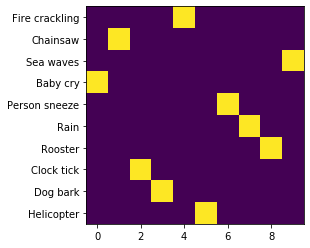

In [155]:
# A typical way to represent a small number of classes (i.e., categories) is 
# using one-hot-encodings, a sparse vector of 0s and 1s 
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
class_names_vec = class_names.reshape(len(class_names), 1)
onehot_encoded = onehot_encoder.fit_transform(class_names_vec)
# Let's take a look at the one-hot-encodings 
plt.imshow(onehot_encoded)
plt.yticks(range(0,10),class_names)      

In [166]:
# let's listen to some of the audio files, lower the volume if you're wearing headphones! 
filename = dataset_events['Dog bark'][20]
ipd.Audio(filename)

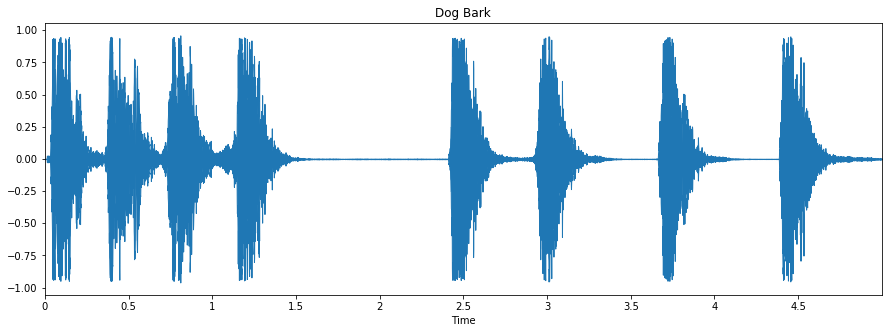

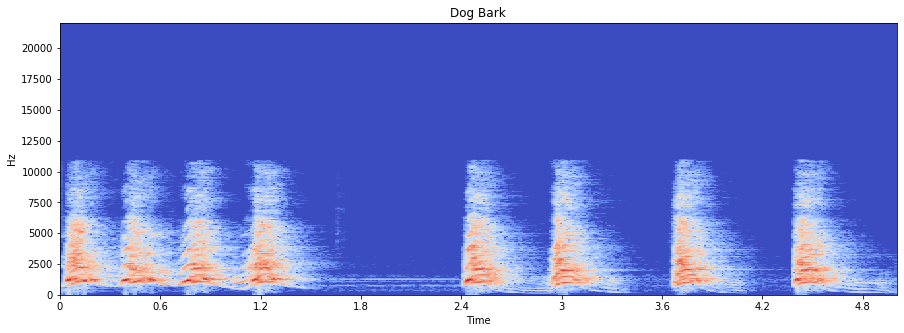

In [206]:
# let's look at this audio file, using wavform library. You could also just plot it with plt.plot()
import librosa.display
filename = dataset_events['Dog bark'][20]
plt.figure(figsize=(15, 5))
plt.title('Dog Bark')
wav_data, sampling_rate = librosa.load(filename)
librosa.display.waveplot(wav_data, sr=sampling_rate)
# The wav form tell us about the number of events,
# but sometimes it's more intuitive to look at the time-frequency representation of audio. 
# We'll use Librosa's implementation of Short-Time Fourier Transform to take our audio from time-only domain to both 
# time and frequency. You'll see some parameters, for now just go with it. We're also going to look at the log(STFT)
# it helps clarifying some of the details in the colormap
plt.figure(figsize=(15, 5))
plt.title('Dog Bark')
X = librosa.stft(wav_data,n_fft=2048, hop_length=256, win_length=1024)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=sampling_rate*2, x_axis='time', y_axis='hz')

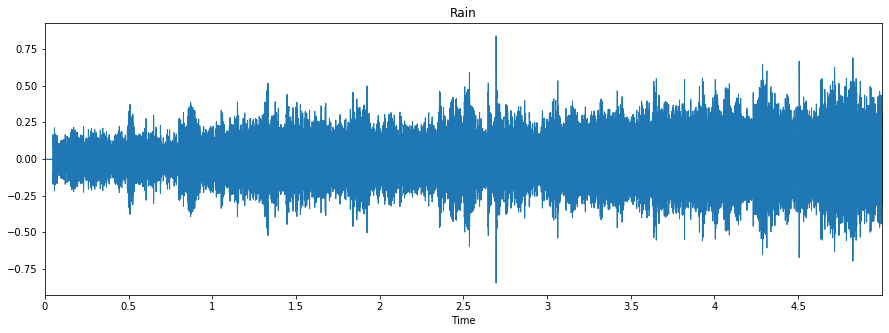

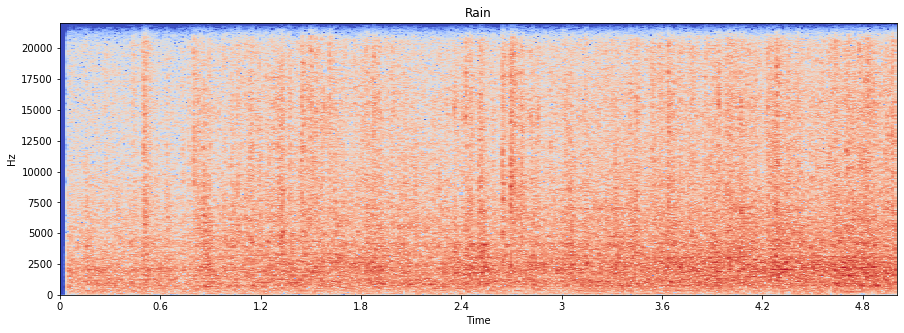

In [205]:
# Let's try another class
filename = dataset_events['Rain'][20]
plt.figure(figsize=(15, 5))
plt.title('Rain')
wav_data, sampling_rate = librosa.load(filename)
librosa.display.waveplot(wav_data, sr=sampling_rate)
plt.figure(figsize=(15, 5))
plt.title('Rain')
X = librosa.stft(wav_data,n_fft=2048, hop_length=256, win_length=1024)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=sampling_rate*2, x_axis='time', y_axis='hz')

### Looking at these two files, you might be able to tell they belong to two different classes, though it might be difficult to tell what the content is without listening to the files. Let's see if we can teach a computer to assign a label to a wav file. We start by reading the audio files, taking their log(abs(STFT)) and creating a new dataset. For the sake of simplicity and time, we're going to average over the STFT over time, aka spectrum. We didn't need to take the STFT to later marginalized over time. We're going to bring the time into the picture and see if it helps our classifier. 

In [422]:
print(len(wav_data)/sampling_rate)

5.001


In [ ]:
# Let's create our new dataset this time it's more tailored for the AI, not humans! 
num_fft = 1024
num_seconds = 5
# This will take a few minutes, so be patient!
AI_dataset = {}
for key in dataset_events.keys(): 
    filenames = dataset_events[key]
    Xlist = []
    for filename in filenames:
        wav_data, sampling_rate = librosa.load(filename,sr= 8000)#resampling the data to 16khz
        if len(wav_data) < sampling_rate*num_seconds: 
            len_zeros = (sampling_rate*num_seconds)-len(wav_data)
            zeros = np.zeros((len_zeros,1)).ravel()
            wav_data = np.concatenate((wav_data,zeros))
        X = librosa.stft(wav_data,n_fft= num_fft, hop_length=num_fft, win_length=num_fft)
        Xdb = librosa.amplitude_to_db(abs(X)).ravel()
        Xlist.append(Xdb)
    AI_dataset[key] = np.asarray(Xlist)
    
# You should see 40 classes 
print(np.shape(AI_dataset['Rain']))

# Visualizing feature over classes 

### Now, you might be curious if the features you extracted are sepreable. There are 129 dimensions, so we'll need to project them down to lower dimensions. There are several methods to do this, we're going to use t-distributed stochastic neighbor embedding, TSNE. Don't worry about the details here, just know that TSNE is a tool that help us visualize high dimensional data.  

In [415]:
from sklearn.manifold import TSNE
num_classes = 10 
num_per_class = 40 
Xs = np.zeros((num_classes*num_per_class,ndim)) #400*ndim
for idx,key in enumerate(AI_dataset.keys()):
    Xs[idx*num_per_class:(idx+1)*num_per_class,:] = np.array(AI_dataset[key])

In [420]:
# Apply TSNE 
print(Xs.shape)
X_embedded = TSNE(n_components=2).fit_transform(Xs)
print(X_embedded.shape)

(400, 24510)


(400, 2)

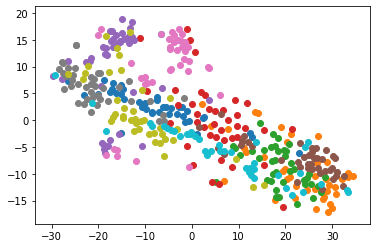

In [418]:
# Scatter plot TSNE 
b = [0,num_per_class]
for i in range(num_classes): 
    plt.scatter(X_embedded[b[0]+(i*num_per_class):b[1]+(i*num_per_class),0],
                X_embedded[b[0]+(i*num_per_class):b[1]+(i*num_per_class),1])